## Testando Prompt (usando classe nas tools)

### Tokens e imports

In [2]:
import os
from getpass import getpass

os.environ["DEEPINFRA_API_TOKEN"] = getpass("Digite sua chave da DeepInfra: ")

In [3]:

from langchain_community.chat_models import ChatDeepInfra
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

chat = ChatDeepInfra(model="deepseek-ai/DeepSeek-V3") 


In [ ]:
from getpass import getpass

os.environ["TAVILY_API_KEY"] = getpass("Digite sua chave do Travily: ")
#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

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults(max_results=2)
search_results = tavily.invoke("Qual a temperatura na cidade de Belo Horizonte hoje?")
print(search_results)

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_18060\3558227869.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults(max_results=2)


[{'title': 'Previsão do tempo e clima para hoje em Belo Horizonte - MG', 'url': 'https://www.climatempo.com.br/previsao-do-tempo/cidade/107/belohorizonte-mg', 'content': 'Tempo agora\n\nSatélite\nChuva Agora\n\n## Qual a previsão do tempo para hoje em Belo Horizonte - MG?\n\nA previsão do tempo para hoje é de temperaturas entre 13° e 24° e sem possibilidade de chuva em Belo Horizonte - MG.\n\n## Qual a temperatura de hoje em Belo Horizonte - MG?\n\nA temperatura máxima é de 24° hoje em Belo Horizonte - MG.\n\n## Como é o clima em Belo Horizonte - MG no mês de julho? Qual a média mensal de chuva? [...] ### Alerta de chuva forte e volumosa no litoral de SP e do RJ Mais detalhes\n\n### Alerta de chuva forte e volumosa no litoral de SP e do RJ Mais detalhes\n\n Agora\n Hoje\n Amanhã\n Fim de semana\n 15 dias\n Histórico de dados\n\n# Previsão para Hoje 02/07 Belo Horizonte - MG\n\nHoje\nserá\nparecido com ontem\n\n  \nDia de sol, com muitas nuvens à tarde. À noite a nebulosidade diminui.\n

### Definindo Tools
Aqui eu tentei com classes. 
PROBLEMA: o agente buga ao tentar chamar esses métodos, dá uns bugs com o 'self'

In [7]:
import pandas as pd
from langchain.agents import tool


class CSVAnalysisTools:
    def __init__(self, path: str):
        if not os.path.exists(path):
            raise FileNotFoundError(f"O arquivo não foi encontrado em: {path}")
        self.df = pd.read_csv(path)
        print(f"DataFrame carregado com {self.df.shape[0]} linhas e {self.df.shape[1]} colunas.")

    @tool("get_column_names")
    def get_column_names(self) -> str:
        """
        Retorna uma lista com todos os nomes das colunas do dataset.
        Útil para saber quais colunas estão disponíveis para análise.
        """
        return str(self.df.columns.tolist())

    @tool("summary_statistics")
    def summary_statistics(self, column_name: str) -> str:
        """
        Calcula estatísticas descritivas para uma coluna numérica específica.
        Retorna média, desvio padrão, mínimo, máximo e os quartis.
        """
        try:
            return self.df[column_name].describe().to_string()
        except KeyError:
            return f"Erro: A coluna '{column_name}' não existe. Colunas disponíveis: {self.df.columns.tolist()}"
        except TypeError:
            return f"Erro: A coluna '{column_name}' não parece ser numérica. Tente usar 'value_counts'."

    @tool("value_counts")
    def value_counts(self, column_name: str) -> str:
        """
        Conta a frequência de cada valor único em uma coluna categórica.
        """
        try:
            return self.df[column_name].value_counts().to_string()
        except KeyError:
            return f"Erro: A coluna '{column_name}' não existe. Colunas disponíveis: {self.df.columns.tolist()}"

    @tool("check_missing_values")
    def check_missing_values(self, column_name: str) -> str:
        """
        Verifica e conta a quantidade de valores nulos (NaN) em uma coluna específica.
        """
        try:
            missing_count = self.df[column_name].isnull().sum()
            return f"A coluna '{column_name}' tem {missing_count} valores faltantes."
        except KeyError:
            return f"Erro: A coluna '{column_name}' não existe. Colunas disponíveis: {self.df.columns.tolist()}"

    @tool("calculate_correlation")
    def calculate_correlation(self, column_a: str, column_b: str) -> str:
        """
        Calcula a correlação entre duas colunas numéricas. O valor varia de -1 a 1.
        """
        try:
            correlation = self.df[[column_a, column_b]].corr().iloc[0, 1]
            return f"A correlação entre '{column_a}' e '{column_b}' é: {correlation:.4f}"
        except KeyError as e:
            return f"Erro: Uma das colunas não existe. Coluna não encontrada: {e}. Colunas disponíveis: {self.df.columns.tolist()}"
        except TypeError:
            return f"Erro: Uma ou ambas as colunas não são numéricas. Não é possível calcular a correlação."


In [8]:
analysis_tool_suite = CSVAnalysisTools(path="./datasets/pems03.csv")

tools = [tavily, 
        analysis_tool_suite.get_column_names,
        analysis_tool_suite.summary_statistics,
        analysis_tool_suite.value_counts,
        analysis_tool_suite.check_missing_values,
        analysis_tool_suite.calculate_correlation]

DataFrame carregado com 26208 linhas e 359 colunas.


In [9]:
chat_with_tools = chat.bind_tools(tools)

In [10]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.prompts import HumanMessagePromptTemplate
from langchain.tools.render import render_text_description
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

### Definições LangChain

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [12]:
# ✅ Etapa 2: Definir os nós

def chatbot(state: State):                              # RECEBE UM STATE COMO PARÂMETRO
    return {"messages": [chat_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)              # ADICIONA A ATIVIDADE AO GRAFO

tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)

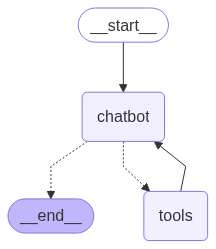

In [13]:
# ✅ Etapa 3: Criar o grafo

graph_builder.add_edge(START, "chatbot")

# chatbot --> tool    é o chatbot quem decide se vai empregar as ferramentas ou não
graph_builder.add_conditional_edges("chatbot", tools_condition)

# tool ---> chatbot   uma vez que a ferramenta foi utilizada ela precisa retornar ao ll,
graph_builder.add_edge("tools", "chatbot")

checkpointer=MemorySaver()
# config = config = {"configurable": {"thread_id": "1"}}  # Uma thread_id para cada conversação

config = {
    "configurable": {
        "api_key": "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",  # key da deepinfra ou 
        "model": "deepseek-ai/DeepSeek-V3",  # Your model
        "thread_id": "1"  # Optional conversation tracking
    }
}

graph = graph_builder.compile(checkpointer=checkpointer)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### Agent Prompting
Essa é a parte que estou focando. Estou tentando usar "Iterative Refinement Prompting" & "Reasoning and Acting"

Possíveis melhorias: usar mais Identity Prompting (mais de uma persona pode ser bom); aprender "Meta Prompting";  aumentar o "Self-reflection Prompts"; usar LLM para gerar o "Iterative Refinement Prompting"


In [ ]:

react_template = """
Você é um analista de dados especialista em Análise Exploratória de Dados (EDA), com foco principal em datasets de séries temporais. Sua tarefa é usar as ferramentas disponíveis para extrair insights valiosos e responder às perguntas do usuário, seguindo um ciclo rigoroso de raciocínio.

Você tem acesso às seguintes ferramentas:
{tools}

### REGRAS DE EXECUÇÃO
1.  **Ciclo de Análise**: Você deve decompor o problema em passos. Para cada passo, você gerará um **Pensamento** e uma **Ação**. Sua resposta DEVE parar após o JSON da Ação.
2.  **Análise da Observação**: Após sua ação, o sistema fornecerá uma **Observação**. Você DEVE analisar esta observação (seja um resultado ou um erro) para formular seu próximo Pensamento e Ação.
3.  **Simplicidade das Ferramentas**: As ferramentas são simples. Elas NÃO aceitam filtros ou lógicas complexas no `action_input`. Se uma tarefa requer múltiplos passos (como filtrar por data e depois contar), você DEVE usar ferramentas em passos separados.
4.  **Formato do Input**: O formato de `action_input` é CRÍTICO. Para ferramentas que pedem um nome de coluna (como `value_counts`), o input deve ser uma STRING SIMPLES (ex: `"Minha_Coluna"`), não um objeto JSON.

### EXEMPLO DE CICLO DE CORREÇÃO (Seu Guia)

Veja um exemplo de como reagir a um erro:

Pergunta: Qual a distribuição da coluna 'Vendas'?
Pensamento: A pergunta é sobre a coluna 'Vendas'. Vou usar a ferramenta `value_counts` para ver a distribuição dos valores.
Ação:
```json
{
"action": "value_counts",
"action_input": {
"column_name": "Vendas"
}
}
```
Observação: Erro: O input para 'value_counts' deve ser uma string, não um objeto.
Pensamento: Ocorreu um erro. A observação diz que o action_input para value_counts deve ser uma string simples, mas eu enviei um objeto JSON. Além disso, não tenho certeza se 'Vendas' é o nome exato da coluna. Vou primeiro verificar todos os nomes de colunas disponíveis para ter certeza e depois tentarei chamar value_counts com o formato correto.
Ação:
```json
{
"action": "get_column_names",
"action_input": {}
}
```
Observação: ['Timestamp', 'Vendas_Totais', 'Regiao', 'ID_Produto']
Pensamento: Agora vejo o nome correto da coluna é 'Vendas_Totais'. Vou chamar value_counts novamente, desta vez com o nome correto e no formato de string simples, como a primeira mensagem de erro instruiu.
Ação:
```json
{
"action": "value_counts",
"action_input": "Vendas_Totais"
}
```
Observação: [Resultado da ferramenta value_counts]
Pensamento: Agora tenho a informação que preciso para responder.
Resposta Final: A distribuição da coluna 'Vendas_Totais' é a seguinte...


SEU TURNO
Agora, siga o mesmo processo. Use o formato abaixo, parando sempre após a Ação.

Formato:
Pergunta: a pergunta de entrada que você deve responder
Pensamento: ...
Ação:
```json
{
"action": "nome da ferramenta",
"action_input": "entrada da ferramenta"
}
```

"""

prompt_template = ChatPromptTemplate.from_messages(
                [
                    SystemMessage(content=react_template, input_variables=['tool_names', 'tools']),
                    HumanMessagePromptTemplate.from_template("{question}"),
                ]
            )


prompt = prompt_template.partial(
    tools=render_text_description(tools),
    tool_names=", ".join([t.name for t in tools]),
)


Tentando conversar com o agente

In [ ]:
# ✅ Etapa 5: Conversar com o agente
estado = graph.invoke({"messages": prompt.format_messages(question = "Oi, como é nosso dataset?")}, config)

In [98]:
estado["messages"][-1].content

'Pensamento: Para entender melhor o dataset, primeiro preciso saber quais colunas estão disponíveis. Vou usar a ferramenta `get_column_names` para obter a lista de colunas.\n\nAção:\n```json\n{\n"action": "get_column_names",\n"action_input": {}\n}\n```'